In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

def focal_loss(inputs, targets, alpha=0.25, gamma=2.0, reduction='mean'):
    #print("inputs size = ", inputs.size())
    # inputs size =  torch.Size([1, 2, 1024, 1024])
    #print("targets size = ", targets.size())
    # targets size =  torch.Size([1, 1024, 1024])
    BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    F_loss = at * (1 - pt)**gamma * BCE_loss

    if reduction == 'mean':
        return torch.mean(F_loss), (1 - pt)**gamma
    elif reduction == 'sum':
        return torch.sum(F_loss)
    else:
        return F_loss

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    # original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Focal Loss , not sure about alpha and gamme
    #original_loss = focal_loss(student_outputs[:,1,:,:], labels.squeeze(1).float(), alpha=0.25, gamma=2.0)
    alpha=0.25
    gamma=2.0
    targets = labels.squeeze(1).float()
    BCE_loss = F.binary_cross_entropy_with_logits(student_outputs[:,1,:,:], targets, reduction='none')
    targets = targets.type(torch.float32)
    at = alpha * targets + (1 - alpha) * (1 - targets)
    pt = torch.exp(-BCE_loss)
    modulating_number = torch.mean((1 - pt)**gamma)
    F_loss = at * modulating_number * BCE_loss
    #print("modulating_number = ", modulating_number)
    # mean
    original_loss = torch.mean(F_loss)
    #print("original loss = ", original_loss)

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))
    #print("distillation loss = ", distillation_loss)
    
    # total loss
    #total_loss = modulating_number*((1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss)
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss*modulating_number
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)

            # Calculate Focal Loss , not sure about alpha and gamme
            #print("outputs size = ", outputs['out'].size())
            #print("mask size = ", mask.size())
            # outputs['out'] size =  torch.Size([1, 2, 1024, 1024])
            # mask size =  torch.Size([1, 1, 1024, 1024])
            #loss = focal_loss(outputs['out'][:,1:2,:,:], mask.float())
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則新增它
    #weights_dir = os.path.join(os.getcwd(),"weights")
    weights_dir = os.path.join(os.getcwd(), f"weights/weights_KD_segformer_0616/weights_KD_segformer_0616_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

class MySegFormer_0604(nn.Module):
    def __init__(self,num_classes,backbone="b0",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}
        # 在conda 環境裡huggingface包好的Segformer有改(modeling_segformer.py)

# Student Model: Segformer 0601
backbone = "b0"
num_classes = 2
model_segformer = MySegFormer_0604(num_classes, backbone)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        # Please replace Diatillation_Loss_Ratio to the teacher_ratio from 0 ~ 1 
        teacher_ratio = 0.8
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b0 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should pro

FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10
1/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - loss: 0.0307

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 542ms/step - loss: 0.0243
Average validation loss: 0.533414363861084
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 553ms/step - loss: 0.0243 - val_loss: 0.5334
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_5.pth'.
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 775ms/step - loss: 0.0179 - val_loss: 0.5334
Average validation loss: 0.48731061816215515
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 792ms/step - loss: 0.0179 - val_loss: 0.5104
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_5.pth'.
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 810ms/step - loss: 0.0137 - val_loss: 0.5104
Average validation loss: 0.3356701731681824
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 829ms/step - loss: 0.0137 - val_loss: 0.4521
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_seg

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 853ms/step - loss: 7.5464e-06
Average validation loss: 0.08611847832798958
8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 862ms/step - loss: 7.5464e-06 - val_loss: 0.0861
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_10.pth'.
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 835ms/step - loss: 7.3298e-06 - val_loss: 0.0861
Average validation loss: 0.10777834057807922
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 847ms/step - loss: 7.3298e-06 - val_loss: 0.0969
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 833ms/step - loss: 7.1157e-06 - val_loss: 0.0969
Average validation loss: 0.06101069226861
8/8 ━━━━━━━━━━━━━━━━━━━━ 21s 845ms/step - loss: 7.1157e-06 - val_loss: 0.0850
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_10.pth'.
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 903ms/step - loss: 6.8141e-06 - val_loss: 0.0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 765ms/step - loss: 1.8313e-06
Average validation loss: 0.015331900678575039
12/12 ━━━━━━━━━━━━━━━━━━━━ 9s 777ms/step - loss: 1.8313e-06 - val_loss: 0.0153
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_15.pth'.
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 780ms/step - loss: 1.6945e-06 - val_loss: 0.0153
Average validation loss: 0.01285932290678223
12/12 ━━━━━━━━━━━━━━━━━━━━ 19s 789ms/step - loss: 1.6945e-06 - val_loss: 0.0141
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_15.pth'.
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 830ms/step - loss: 1.5493e-06 - val_loss: 0.0141
Average validation loss: 0.013579673133790493
12/12 ━━━━━━━━━━━━━━━━━━━━ 29s 839ms/step - loss: 1.5493e-06 - val_loss: 0.0139
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 38s 777ms/step - loss: 1.4841e

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 835ms/step - loss: 1.5256e-06
Average validation loss: 0.009701118804514408
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 847ms/step - loss: 1.5256e-06 - val_loss: 0.0097
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_20.pth'.
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 815ms/step - loss: 1.2558e-06 - val_loss: 0.0097
Average validation loss: 0.009259419864974916
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 827ms/step - loss: 1.2558e-06 - val_loss: 0.0095
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_20.pth'.
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 843ms/step - loss: 1.1083e-06 - val_loss: 0.0095
Average validation loss: 0.008248371072113514
16/16 ━━━━━━━━━━━━━━━━━━━━ 40s 853ms/step - loss: 1.1083e-06 - val_loss: 0.0091
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 816ms/step - loss: 9.3627e-07
Average validation loss: 0.010113856010138988
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 826ms/step - loss: 9.3627e-07 - val_loss: 0.0101
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_25.pth'.
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 778ms/step - loss: 1.0417e-06 - val_loss: 0.0101
Average validation loss: 0.009566803881898522
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 788ms/step - loss: 1.0417e-06 - val_loss: 0.0098
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_25.pth'.
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 784ms/step - loss: 8.8361e-07 - val_loss: 0.0098
Average validation loss: 0.008856658730655909
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 795ms/step - loss: 8.8361e-07 - val_loss: 0.0095
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 777ms/step - loss: 7.0030e-07
Average validation loss: 0.009164810297079384
24/24 ━━━━━━━━━━━━━━━━━━━━ 19s 786ms/step - loss: 7.0030e-07 - val_loss: 0.0092
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_30.pth'.
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 778ms/step - loss: 5.4780e-07 - val_loss: 0.0092
Average validation loss: 0.0049335228007597225
24/24 ━━━━━━━━━━━━━━━━━━━━ 38s 787ms/step - loss: 5.4780e-07 - val_loss: 0.0070
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_30.pth'.
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 785ms/step - loss: 4.6917e-07 - val_loss: 0.0070
Average validation loss: 0.006604914417645584
24/24 ━━━━━━━━━━━━━━━━━━━━ 57s 794ms/step - loss: 4.6917e-07 - val_loss: 0.0069
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 76s 793ms/step - loss: 4.0

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 817ms/step - loss: 2.1038e-06
Average validation loss: 0.060884040873497726
40/40 ━━━━━━━━━━━━━━━━━━━━ 33s 827ms/step - loss: 2.1038e-06 - val_loss: 0.0609
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_50.pth'.
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 777ms/step - loss: 1.6038e-06 - val_loss: 0.0609
Average validation loss: 0.020722776278853418
40/40 ━━━━━━━━━━━━━━━━━━━━ 64s 787ms/step - loss: 1.6038e-06 - val_loss: 0.0408
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_50.pth'.
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 95s 775ms/step - loss: 1.3188e-06 - val_loss: 0.0408
Average validation loss: 0.02866425693500787
40/40 ━━━━━━━━━━━━━━━━━━━━ 96s 786ms/step - loss: 1.3188e-06 - val_loss: 0.0368
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 127s 778ms/step - loss: 1.11

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 ━━━━━━━━━━━━━━━━━━━━ 36s 749ms/step - loss: 3.8848e-06
Average validation loss: 0.017946254811249673
48/48 ━━━━━━━━━━━━━━━━━━━━ 37s 760ms/step - loss: 3.8848e-06 - val_loss: 0.0179
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_60.pth'.
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 778ms/step - loss: 3.6376e-06 - val_loss: 0.0179
Average validation loss: 0.027537668667112786
48/48 ━━━━━━━━━━━━━━━━━━━━ 74s 790ms/step - loss: 3.6376e-06 - val_loss: 0.0227
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 775ms/step - loss: 3.1474e-06 - val_loss: 0.0227
Average validation loss: 0.026729129099597532
48/48 ━━━━━━━━━━━━━━━━━━━━ 112s 787ms/step - loss: 3.1474e-06 - val_loss: 0.0241
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 150s 783ms/step - loss: 2.6446e-06 - val_loss: 0.0241
Average validation loss: 0.007322306725351761
48/48 ━━━━━━━━━━━━━━━━━━━━ 150s 795ms/step - loss: 2.6446e-06 - val_loss: 0.0199
S

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 822ms/step - loss: 9.6656e-07
Average validation loss: 0.01702625464115824
56/56 ━━━━━━━━━━━━━━━━━━━━ 47s 834ms/step - loss: 9.6656e-07 - val_loss: 0.0170
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_70.pth'.
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 878ms/step - loss: 7.8989e-07 - val_loss: 0.0170
Average validation loss: 0.1306396531207221
56/56 ━━━━━━━━━━━━━━━━━━━━ 96s 890ms/step - loss: 7.8989e-07 - val_loss: 0.0738
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 143s 839ms/step - loss: 7.2696e-07 - val_loss: 0.0738
Average validation loss: 0.006848513880478484
56/56 ━━━━━━━━━━━━━━━━━━━━ 144s 851ms/step - loss: 7.2696e-07 - val_loss: 0.0515
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_70.pth'.
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 196s 920ms/step - loss: 6.37

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 775ms/step - loss: 4.5927e-06
Average validation loss: 0.03289829316781834
64/64 ━━━━━━━━━━━━━━━━━━━━ 50s 787ms/step - loss: 4.5927e-06 - val_loss: 0.0329
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_80.pth'.
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 100s 775ms/step - loss: 3.9534e-06 - val_loss: 0.0329
Average validation loss: 0.016482823208207265
64/64 ━━━━━━━━━━━━━━━━━━━━ 101s 786ms/step - loss: 3.9534e-06 - val_loss: 0.0247
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_80.pth'.
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 780ms/step - loss: 4.2037e-06 - val_loss: 0.0247
Average validation loss: 0.014077869462198578
64/64 ━━━━━━━━━━━━━━━━━━━━ 151s 791ms/step - loss: 4.2037e-06 - val_loss: 0.0212
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 ━━━━━━━━━━━━━━━━━━━━ 56s 775ms/step - loss: 6.6697e-07
Average validation loss: 0.009515517701705297
72/72 ━━━━━━━━━━━━━━━━━━━━ 57s 786ms/step - loss: 6.6697e-07 - val_loss: 0.0095
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_90.pth'.
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 777ms/step - loss: 5.0199e-07 - val_loss: 0.0095
Average validation loss: 0.030504505408720836
72/72 ━━━━━━━━━━━━━━━━━━━━ 113s 788ms/step - loss: 5.0199e-07 - val_loss: 0.0200
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 169s 777ms/step - loss: 4.0490e-07 - val_loss: 0.0200
Average validation loss: 0.014674549586036138
72/72 ━━━━━━━━━━━━━━━━━━━━ 170s 788ms/step - loss: 4.0490e-07 - val_loss: 0.0182
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 226s 776ms/step - loss: 3.5672e-07 - val_loss: 0.0182
Average validation loss: 0.0217222623889231
72/72 ━━━━━━━━━━━━━━━━━━━━ 227s 787ms/step - loss: 3.5672e-07 - val_loss: 0.0191
E

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 ━━━━━━━━━━━━━━━━━━━━ 62s 776ms/step - loss: 3.4613e-07
Average validation loss: 0.034406621591188014
80/80 ━━━━━━━━━━━━━━━━━━━━ 63s 786ms/step - loss: 3.4613e-07 - val_loss: 0.0344
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_100.pth'.
Epoch 2/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 132s 867ms/step - loss: 2.6642e-07 - val_loss: 0.0344
Average validation loss: 0.00790954865515232
80/80 ━━━━━━━━━━━━━━━━━━━━ 133s 878ms/step - loss: 2.6642e-07 - val_loss: 0.0212
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_100.pth'.
Epoch 3/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 206s 905ms/step - loss: 2.2983e-07 - val_loss: 0.0212
Average validation loss: 0.008021428773645312
80/80 ━━━━━━━━━━━━━━━━━━━━ 207s 915ms/step - loss: 2.2983e-07 - val_loss: 0.0168
Epoch 4/10
80/80 ━━━━━━━━━━━━━━━━━━━━ 269s 778ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 ━━━━━━━━━━━━━━━━━━━━ 76s 794ms/step - loss: 4.0540e-06
Average validation loss: 0.014484765920011947
96/96 ━━━━━━━━━━━━━━━━━━━━ 77s 805ms/step - loss: 4.0540e-06 - val_loss: 0.0145
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_120.pth'.
Epoch 2/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 151s 765ms/step - loss: 2.7685e-06 - val_loss: 0.0145
Average validation loss: 0.01152820696006529
96/96 ━━━━━━━━━━━━━━━━━━━━ 152s 776ms/step - loss: 2.7685e-06 - val_loss: 0.0130
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_120.pth'.
Epoch 3/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 225s 763ms/step - loss: 2.0166e-06 - val_loss: 0.0130
Average validation loss: 0.023098358845648665
96/96 ━━━━━━━━━━━━━━━━━━━━ 226s 774ms/step - loss: 2.0166e-06 - val_loss: 0.0164
Epoch 4/10
96/96 ━━━━━━━━━━━━━━━━━━━━ 301s 775ms/step - loss

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 ━━━━━━━━━━━━━━━━━━━━ 94s 786ms/step - loss: 1.9848e-06
Average validation loss: 0.018260065264378986
120/120 ━━━━━━━━━━━━━━━━━━━━ 96s 797ms/step - loss: 1.9848e-06 - val_loss: 0.0183
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_150.pth'.
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 190s 786ms/step - loss: 1.4644e-06 - val_loss: 0.0183
Average validation loss: 0.009883015742525458
120/120 ━━━━━━━━━━━━━━━━━━━━ 191s 797ms/step - loss: 1.4644e-06 - val_loss: 0.0141
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_150.pth'.
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 285s 779ms/step - loss: 1.1518e-06 - val_loss: 0.0141
Average validation loss: 0.009418869911072155
120/120 ━━━━━━━━━━━━━━━━━━━━ 286s 790ms/step - loss: 1.1518e-06 - val_loss: 0.0125
Saved model weights to 'c:\天_11157065\git\Rippl

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 ━━━━━━━━━━━━━━━━━━━━ 112s 776ms/step - loss: 1.5997e-06
Average validation loss: 0.013050020180849565
144/144 ━━━━━━━━━━━━━━━━━━━━ 113s 787ms/step - loss: 1.5997e-06 - val_loss: 0.0131
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_180.pth'.
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 225s 777ms/step - loss: 1.2245e-06 - val_loss: 0.0131
Average validation loss: 0.015474132543507343
144/144 ━━━━━━━━━━━━━━━━━━━━ 227s 787ms/step - loss: 1.2245e-06 - val_loss: 0.0143
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 338s 773ms/step - loss: 9.7326e-07 - val_loss: 0.0143
Average validation loss: 0.013655004240313752
144/144 ━━━━━━━━━━━━━━━━━━━━ 340s 784ms/step - loss: 9.7326e-07 - val_loss: 0.0141
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 451s 774ms/step - loss: 8.1511e-07 - val_loss: 0.0141
Average validation loss: 0.01624443147900618
144/144 ━━━━━━━━━━━━━━━━━━━━ 453s 785ms/step - loss: 8.1511e-07 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 ━━━━━━━━━━━━━━━━━━━━ 124s 777ms/step - loss: 1.2685e-06
Average validation loss: 0.02655717793786607
160/160 ━━━━━━━━━━━━━━━━━━━━ 126s 788ms/step - loss: 1.2685e-06 - val_loss: 0.0266
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_200.pth'.
Epoch 2/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 251s 784ms/step - loss: 9.1397e-07 - val_loss: 0.0266
Average validation loss: 0.016224641692588193
160/160 ━━━━━━━━━━━━━━━━━━━━ 253s 794ms/step - loss: 9.1397e-07 - val_loss: 0.0214
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_200.pth'.
Epoch 3/10
160/160 ━━━━━━━━━━━━━━━━━━━━ 380s 792ms/step - loss: 7.3224e-07 - val_loss: 0.0214
Average validation loss: 0.011317738489015027
160/160 ━━━━━━━━━━━━━━━━━━━━ 382s 802ms/step - loss: 7.3224e-07 - val_loss: 0.0180
Saved model weights to 'c:\天_11157065\git\Ripp

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 ━━━━━━━━━━━━━━━━━━━━ 158s 788ms/step - loss: 7.6970e-07
Average validation loss: 0.014583111350948457
200/200 ━━━━━━━━━━━━━━━━━━━━ 160s 799ms/step - loss: 7.6970e-07 - val_loss: 0.0146
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_250.pth'.
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 315s 777ms/step - loss: 5.9712e-07 - val_loss: 0.0146
Average validation loss: 0.024893389688804744
200/200 ━━━━━━━━━━━━━━━━━━━━ 317s 788ms/step - loss: 5.9712e-07 - val_loss: 0.0197
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 474s 782ms/step - loss: 5.2448e-07 - val_loss: 0.0197
Average validation loss: 0.04904565782873527
200/200 ━━━━━━━━━━━━━━━━━━━━ 476s 793ms/step - loss: 5.2448e-07 - val_loss: 0.0295
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 632s 778ms/step - loss: 7.1561e-07 - val_loss: 0.0295
Average validation loss: 0.017628156890859826
200/200 ━━━━━━━━━━━━━━━━━━━━ 634s 789ms/step - loss: 7.1561e-07 

c:\Users\user\anaconda3\envs\KD_train_02\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 ━━━━━━━━━━━━━━━━━━━━ 190s 789ms/step - loss: 9.5146e-07
Average validation loss: 0.015569079922958433
240/240 ━━━━━━━━━━━━━━━━━━━━ 192s 800ms/step - loss: 9.5146e-07 - val_loss: 0.0156
Saved model weights to 'c:\天_11157065\git\RipplesDetection\ar1DB\weights/weights_KD_segformer_0616/weights_KD_segformer_0616_80\segformer_data_size_300.pth'.
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 377s 772ms/step - loss: 1.0510e-06 - val_loss: 0.0156
Average validation loss: 0.057760831682632366
240/240 ━━━━━━━━━━━━━━━━━━━━ 380s 783ms/step - loss: 1.0510e-06 - val_loss: 0.0367
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 567s 778ms/step - loss: 9.4900e-07 - val_loss: 0.0367
Average validation loss: 0.0233272418491462
240/240 ━━━━━━━━━━━━━━━━━━━━ 569s 789ms/step - loss: 9.4900e-07 - val_loss: 0.0322
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 755s 773ms/step - loss: 8.0821e-07 - val_loss: 0.0322
Average validation loss: 0.016587133496977914
240/240 ━━━━━━━━━━━━━━━━━━━━ 757s 783ms/step - loss: 8.0821e-07 -

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.10929057598114014, 0.051607573847286405, 0.01667796007124707, 0.0098197052848991, 0.007327237761113793, 0.007691612700000405, 0.019813638574443758, 0.021027211932814677, 0.021187936490834024, 0.020542759579548146, 0.017187122053259778, 0.019548411106690766, 0.020456244059799546, 0.014266199615444444, 0.028211509259096296, 0.05481080658513781, 0.024180527224697587, 0.03916404329420248]
std_val_losses =  [0.1140941026497423, 0.044313135337061556, 0.029126982205686266, 0.006682630073509618, 0.0020880467959593493, 0.002570300254247727, 0.013356091094749003, 0.020302116769135847, 0.03575031710479051, 0.010703113967757121, 0.01942302107592041, 0.013315899885225418, 0.017604254014513935, 0.004001184764081676, 0.017388835736128008, 0.05599994951769961, 0.013817575173855247, 0.0318293935610018]


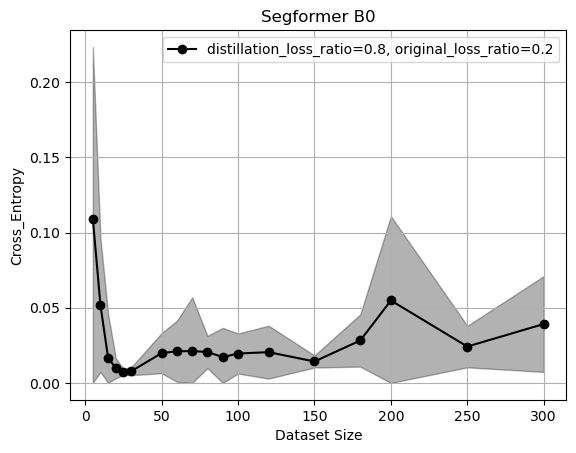

In [2]:
import os
import json

print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

results_dir = os.path.join(os.getcwd(), 'TrainingRecords', 'results_KD_segformer_0616')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

results = {
    "train_sizes": train_sizes,
    "mean_val_losses": mean_val_losses,
    "std_val_losses": std_val_losses
}
json_path = os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.json")
with open(json_path, 'w') as json_file:
    json.dump(results, json_file, indent=4)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.savefig(os.path.join(results_dir, f"results_KD_segformer_0616_{int(teacher_ratio*100)}.png"))

plt.show()